In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random, os, pathlib

import torch
import torch.nn as nn
from torch.utils import data

## MNIST dataset

In [2]:
import datasets
from classes import *

In [3]:
mnist = datasets.MNIST()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

# train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [4]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)
test_label = torch.LongTensor(test_label_)

In [5]:
input_size = 784
output_size = 10

learning_rate = 0.0001
batch_size = 50

In [6]:
network_seeds = [147, 258, 369]
# network_seeds = [369]
network_seed = 369

EPOCHS = 20

actf = nn.LeakyReLU
# actf = nn.ELU

learning_rate = 0.005
lambda_ = 2
criterion = nn.BCELoss()
sigmoid = nn.Sigmoid()

use_mixup = True

In [7]:
class MNIST_OneClass_Balanced(data.Dataset):
    
    def __init__(self, data, label, class_index):
        self.data = data
        self.label = label
        self.class_index = class_index
        
        mask = (label==class_index)
        self.label = mask.type(torch.float32).reshape(-1,1)
        self.class_data = torch.nonzero(mask).reshape(-1)
        self.other_data = torch.nonzero(~mask).reshape(-1)
        
        random.seed(network_seed)
        self._shuffle_data_()
        self.count = 0
        
    def __len__(self):
        return 2*len(self.class_data)
    
    def _shuffle_data_(self):
#         randidx = np.random.permutation(len(self.other_data))
        randidx = random.sample(range(len(self.other_data)), k=len(self.other_data))
        self.other_data = self.other_data[randidx]
    
    def __getitem__(self, idx):
        if idx < len(self.class_data):
            idx = self.class_data[idx]
            img, lbl = self.data[idx], self.label[idx]
        else:
            idx = self.other_data[idx-len(self.class_data)]
            img, lbl = self.data[idx], self.label[idx]
            self.count += 1
            if self.count >= len(self.class_data): 
                self._shuffle_data_()
                self.count = 0
        return img, lbl

In [8]:
# class_idx = 0
# train_dataset = MNIST_OneClass_Balanced(train_data, train_label, class_idx)
# test_dataset = MNIST_OneClass_Balanced(test_data, test_label, class_idx)

In [9]:
# len(train_dataset), len(test_dataset)

In [10]:
# train_loader_all = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
# test_loader_all = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

In [11]:
# %matplotlib inline
# # img, lbl = train_dataset[11010]
# img, lbl = test_dataset[10]
# print(lbl)
# plt.imshow(img.reshape(28,28))

## Convex

In [10]:
class UnivariateCNN(nn.Module):
    
    def __init__(self, channels:list, actf=nn.LeakyReLU):
        super().__init__()
        assert len(channels)>1

        layers = []
        for i in range(len(channels)-1):
            la = nn.Conv2d(channels[i], channels[i+1], kernel_size=(5,5), stride=2, padding=1)
            layers.append(la)
            layers.append(actf())
        layers.append(nn.AdaptiveAvgPool2d(1))
        self.features = nn.Sequential(*layers)
        self.fc = nn.Sequential(nn.Linear(channels[-1], 1))
        
    def forward(self, x):
        x = x.reshape(-1,1, 28, 28)
        x = self.features(x)
        s = x.shape
        return self.fc(x.reshape(s[0], s[1]))    
    

class ConvexCNN(nn.Module):
    
    def __init__(self, channels:list, actf=nn.LeakyReLU):
        super().__init__()
        assert len(channels)>1

        layers = []
        for i in range(len(channels)-1):
            la = nn.Conv2d(channels[i], channels[i+1], kernel_size=(5,5), stride=2, padding=1)
            layers.append(la)
            if i>0:
                layers[-1].weight.data *= 0.2
            layers.append(actf())
        layers.append(nn.AdaptiveAvgPool2d(1))
        self.features = nn.Sequential(*layers)
        self.fc = nn.Sequential(nn.Linear(channels[-1], 1))
        
    def forward(self, x):
        x = x.reshape(-1,1,28, 28)
        for i in range(2, len(self.features)-1, 2):
            self.features[i].weight.data.abs_()
        for i in range(0, len(self.fc), 2):
            self.fc[i].weight.data.abs_()
            
        x = self.features(x)
        s = x.shape
        return self.fc(x.reshape(s[0], s[1]))    
    


In [15]:
# cnn = UnivariateCNN([1, 16, 32, 64])
cnn = ConvexCNN([1, 16, 32, 64])
cnn(torch.randn(2,1,28,28))

tensor([[3.5963],
        [3.4754]], grad_fn=<AddmmBackward0>)

In [21]:
a = nn.Sequential(nn.Conv2d(1, 1, kernel_size=5, padding=2, stride=2),
             nn.Conv2d(1,1, kernel_size=5, padding=2, stride=2))
# b = nn.Conv2d(1, 1, kernel_size=5, padding=2, stride=4)
b = nn.Conv2d(1, 1, kernel_size=5, padding=2, stride=2, dilation=2)
x = torch.randn(2,1,32,32)

a(x).shape, b(x).shape

(torch.Size([2, 1, 8, 8]), torch.Size([2, 1, 14, 14]))

In [22]:
a = nn.Sequential(nn.Conv2d(1, 1, kernel_size=5, padding=2, stride=2),
                 nn.Conv2d(1,1, kernel_size=5, padding=2, stride=2),
                 nn.Conv2d(1,1, kernel_size=5, padding=2, stride=2))
b = nn.Conv2d(1, 1, kernel_size=5, padding=2, stride=4, dilation=4)
x = torch.randn(2,1,28,28)
# nn.Conv2d()

a(x).shape, b(x).shape

(torch.Size([2, 1, 4, 4]), torch.Size([2, 1, 4, 4]))

In [17]:
stat_per_class = []
net_list = []
for class_idx in range(10):
    print(class_idx)
    train_dataset = MNIST_OneClass_Balanced(train_data, train_label, class_idx)
    test_dataset = MNIST_OneClass_Balanced(test_data, test_label, class_idx)

    train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

    torch.manual_seed(network_seed)
    Net = ConvexCNN([1, 16, 32], actf)
    optimizer = torch.optim.Adam(Net.parameters(), lr=learning_rate)
    losses = []
    train_accs = []
    test_accs = []

    index = 0
    for epoch in range(20):
        train_acc = 0
        train_count = 0
        for xx, yy in train_loader:
            index += 1
            if use_mixup:
                rand_indx = np.random.permutation(len(xx))
                rand_lambda = 1-torch.rand(len(xx), 1)*0.1
                x_mix = rand_lambda*xx+(1-rand_lambda)*xx[rand_indx]
                y_mix = rand_lambda*yy+(1-rand_lambda)*yy[rand_indx]
            else:
                x_mix = xx
                y_mix = yy

            yout = sigmoid(Net(x_mix))    
            loss = criterion(yout, y_mix)
            losses.append(float(loss))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
            correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
            train_acc += correct
            train_count += len(outputs)

#             if index%200 == 0:
        train_accs.append(float(train_acc)/train_count*100)
        train_acc = 0
        train_count = 0

        print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
        test_count = 0
        test_acc = 0
        for xx, yy in test_loader:
            with torch.no_grad():
                yout = sigmoid(Net(xx))
            outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
            correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
            test_acc += correct
            test_count += len(xx)
        test_accs.append(float(test_acc)/test_count*100)
        print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
        print()
                
    ### after each class index is finished training
    stat_per_class.append(
    f'Class: {class_idx} -> Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}'
    )
    print(stat_per_class[-1], '\n')
    net_list.append(Net)

0
Epoch: 0:237,  Loss:0.502179741859436
Train Acc:71.64%, Test Acc:74.69%

Epoch: 1:474,  Loss:0.41291874647140503
Train Acc:84.88%, Test Acc:87.40%

Epoch: 2:711,  Loss:0.2867847979068756
Train Acc:89.68%, Test Acc:75.87%

Epoch: 3:948,  Loss:0.23302306234836578
Train Acc:91.80%, Test Acc:87.96%

Epoch: 4:1185,  Loss:0.28443029522895813
Train Acc:92.55%, Test Acc:88.98%

Epoch: 5:1422,  Loss:0.2573814392089844
Train Acc:92.99%, Test Acc:94.54%

Epoch: 6:1659,  Loss:0.20436663925647736
Train Acc:93.89%, Test Acc:90.31%

Epoch: 7:1896,  Loss:0.2413509041070938
Train Acc:93.53%, Test Acc:91.38%

Epoch: 8:2133,  Loss:0.1579991579055786
Train Acc:94.61%, Test Acc:90.51%

Epoch: 9:2370,  Loss:0.17704105377197266
Train Acc:94.43%, Test Acc:95.00%

Epoch: 10:2607,  Loss:0.25889015197753906
Train Acc:94.83%, Test Acc:93.88%

Epoch: 11:2844,  Loss:0.1945742964744568
Train Acc:95.03%, Test Acc:96.33%

Epoch: 12:3081,  Loss:0.11924849450588226
Train Acc:95.13%, Test Acc:91.94%

Epoch: 13:3318,  L

Train Acc:93.29%, Test Acc:93.83%

Epoch: 4:1085,  Loss:0.24745318293571472
Train Acc:94.83%, Test Acc:96.13%

Epoch: 5:1302,  Loss:0.20287036895751953
Train Acc:95.03%, Test Acc:95.80%

Epoch: 6:1519,  Loss:0.1972137689590454
Train Acc:95.42%, Test Acc:96.30%

Epoch: 7:1736,  Loss:0.25880295038223267
Train Acc:95.67%, Test Acc:95.63%

Epoch: 8:1953,  Loss:0.2320770025253296
Train Acc:95.99%, Test Acc:95.91%

Epoch: 9:2170,  Loss:0.246842160820961
Train Acc:96.19%, Test Acc:93.05%

Epoch: 10:2387,  Loss:0.14881765842437744
Train Acc:96.37%, Test Acc:96.64%

Epoch: 11:2604,  Loss:0.22326210141181946
Train Acc:96.26%, Test Acc:96.86%

Epoch: 12:2821,  Loss:0.1039741262793541
Train Acc:96.19%, Test Acc:96.36%

Epoch: 13:3038,  Loss:0.11739006638526917
Train Acc:96.35%, Test Acc:96.75%

Epoch: 14:3255,  Loss:0.22225986421108246
Train Acc:96.55%, Test Acc:96.08%

Epoch: 15:3472,  Loss:0.1546502411365509
Train Acc:96.57%, Test Acc:95.18%

Epoch: 16:3689,  Loss:0.19527067244052887
Train Acc:9

In [18]:
## find the classification error from classification per class network.
acc_test = 0
count_test = 0
with torch.no_grad():
    for index in range(len(test_label) // batch_size):
        xx = test_data[index * batch_size:(index + 1) * batch_size]
        yy = test_label[index * batch_size:(index + 1) * batch_size]
        yout = []
        for net in net_list:
            yout.append(sigmoid(net(xx)).reshape(-1))
        yout = torch.stack(yout, dim=1).argmax(dim=1)
        acc = (yout == yy).type(torch.float32).sum()
        count_test += len(xx)
        acc_test += acc
        
for s in stat_per_class:
    print(s)
print(f"Total Accuracy (Argmax) is : {float(acc_test/count_test)}")

Class: 0 -> Train Acc 96.08306601384433 ; Test Acc 96.3265306122449
Class: 1 -> Train Acc 98.47967962029071 ; Test Acc 98.98678414096916
Class: 2 -> Train Acc 96.07250755287009 ; Test Acc 97.14147286821705
Class: 3 -> Train Acc 96.19148589137171 ; Test Acc 97.32673267326733
Class: 4 -> Train Acc 96.7819239986306 ; Test Acc 97.50509164969449
Class: 5 -> Train Acc 97.12230215827337 ; Test Acc 96.8609865470852
Class: 6 -> Train Acc 97.22034471105103 ; Test Acc 97.54697286012527
Class: 7 -> Train Acc 96.19313647246608 ; Test Acc 96.20622568093385
Class: 8 -> Train Acc 93.98393437019314 ; Test Acc 96.14989733059548
Class: 9 -> Train Acc 92.49453689695747 ; Test Acc 91.97224975222993
Total Accuracy (Argmax) is : 0.9412000179290771


In [ ]:
sum([p.numel() for p in net.parameters()])

## NN

In [19]:
stat_per_class = []
net_list = []
for class_idx in range(10):
    print(class_idx)
    train_dataset = MNIST_OneClass_Balanced(train_data, train_label, class_idx)
    test_dataset = MNIST_OneClass_Balanced(test_data, test_label, class_idx)

    train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

    torch.manual_seed(network_seed)
    Net = UnivariateCNN([1, 16, 32], actf)
    optimizer = torch.optim.Adam(Net.parameters(), lr=learning_rate)
    losses = []
    train_accs = []
    test_accs = []

    index = 0
    for epoch in range(20):
        train_acc = 0
        train_count = 0
        for xx, yy in train_loader:
            index += 1

            if use_mixup:
                rand_indx = np.random.permutation(len(xx))
                rand_lambda = 1-torch.rand(len(xx), 1)*0.1
                x_mix = rand_lambda*xx+(1-rand_lambda)*xx[rand_indx]
                y_mix = rand_lambda*yy+(1-rand_lambda)*yy[rand_indx]
            else:
                x_mix = xx
                y_mix = yy

            yout = sigmoid(Net(x_mix))    
            loss = criterion(yout, y_mix)
            losses.append(float(loss))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
            correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
            train_acc += correct
            train_count += len(outputs)

#             if index%200 == 0:
        train_accs.append(float(train_acc)/train_count*100)
        train_acc = 0
        train_count = 0

        print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
        test_count = 0
        test_acc = 0
        for xx, yy in test_loader:
            with torch.no_grad():
                yout = sigmoid(Net(xx))
            outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
            correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
            test_acc += correct
            test_count += len(xx)
        test_accs.append(float(test_acc)/test_count*100)
        print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
        print()
                
    ### after each class index is finished training
    stat_per_class.append(
    f'Class: {class_idx} -> Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}'
    )
    print(stat_per_class[-1], '\n')
    net_list.append(Net)

0
Epoch: 0:237,  Loss:0.1804620772600174
Train Acc:86.23%, Test Acc:94.74%

Epoch: 1:474,  Loss:0.18958808481693268
Train Acc:95.75%, Test Acc:97.04%

Epoch: 2:711,  Loss:0.198486790060997
Train Acc:97.21%, Test Acc:97.24%

Epoch: 3:948,  Loss:0.17238833010196686
Train Acc:97.78%, Test Acc:97.81%

Epoch: 4:1185,  Loss:0.13299264013767242
Train Acc:98.27%, Test Acc:98.83%

Epoch: 5:1422,  Loss:0.17925728857517242
Train Acc:98.51%, Test Acc:97.86%

Epoch: 6:1659,  Loss:0.14914283156394958
Train Acc:98.73%, Test Acc:99.23%

Epoch: 7:1896,  Loss:0.13187280297279358
Train Acc:98.97%, Test Acc:99.34%

Epoch: 8:2133,  Loss:0.12645836174488068
Train Acc:99.09%, Test Acc:99.18%

Epoch: 9:2370,  Loss:0.18057182431221008
Train Acc:99.17%, Test Acc:98.62%

Epoch: 10:2607,  Loss:0.16148313879966736
Train Acc:99.07%, Test Acc:98.98%

Epoch: 11:2844,  Loss:0.15103358030319214
Train Acc:99.21%, Test Acc:98.78%

Epoch: 12:3081,  Loss:0.11444096267223358
Train Acc:99.28%, Test Acc:99.34%

Epoch: 13:3318

Epoch: 3:868,  Loss:0.15785810351371765
Train Acc:97.18%, Test Acc:96.97%

Epoch: 4:1085,  Loss:0.18532609939575195
Train Acc:97.84%, Test Acc:97.81%

Epoch: 5:1302,  Loss:0.1583007574081421
Train Acc:98.17%, Test Acc:98.43%

Epoch: 6:1519,  Loss:0.14335201680660248
Train Acc:98.20%, Test Acc:98.43%

Epoch: 7:1736,  Loss:0.21838518977165222
Train Acc:98.45%, Test Acc:98.37%

Epoch: 8:1953,  Loss:0.16314858198165894
Train Acc:98.59%, Test Acc:98.60%

Epoch: 9:2170,  Loss:0.21017208695411682
Train Acc:98.77%, Test Acc:97.03%

Epoch: 10:2387,  Loss:0.14147599041461945
Train Acc:98.74%, Test Acc:98.77%

Epoch: 11:2604,  Loss:0.15156495571136475
Train Acc:98.83%, Test Acc:99.10%

Epoch: 12:2821,  Loss:0.09501968324184418
Train Acc:98.99%, Test Acc:98.54%

Epoch: 13:3038,  Loss:0.08736466616392136
Train Acc:98.81%, Test Acc:98.77%

Epoch: 14:3255,  Loss:0.1709200143814087
Train Acc:99.05%, Test Acc:98.71%

Epoch: 15:3472,  Loss:0.117319256067276
Train Acc:99.04%, Test Acc:98.71%

Epoch: 16:3

In [20]:
## find the classification error from classification per class network.
acc_test = 0
count_test = 0
with torch.no_grad():
    for index in range(len(test_label) // batch_size):
        xx = test_data[index * batch_size:(index + 1) * batch_size]
        yy = test_label[index * batch_size:(index + 1) * batch_size]
        yout = []
        for net in net_list:
            yout.append(sigmoid(net(xx)).reshape(-1))
        yout = torch.stack(yout, dim=1).argmax(dim=1)
        acc = (yout == yy).type(torch.float32).sum()
        count_test += len(xx)
        acc_test += acc
        
for s in stat_per_class:
    print(s)
print(f"Total Accuracy (Argmax) is : {float(acc_test/count_test)}")

Class: 0 -> Train Acc 99.62012493668749 ; Test Acc 99.64285714285714
Class: 1 -> Train Acc 99.67368733313556 ; Test Acc 99.51541850220265
Class: 2 -> Train Acc 99.11883182275932 ; Test Acc 98.74031007751938
Class: 3 -> Train Acc 99.57592562387865 ; Test Acc 99.15841584158416
Class: 4 -> Train Acc 99.60629921259843 ; Test Acc 99.54175152749491
Class: 5 -> Train Acc 99.2897989300867 ; Test Acc 99.10313901345292
Class: 6 -> Train Acc 99.63670158837445 ; Test Acc 99.58246346555325
Class: 7 -> Train Acc 99.50518754988029 ; Test Acc 99.17315175097276
Class: 8 -> Train Acc 99.29926508289182 ; Test Acc 98.92197125256673
Class: 9 -> Train Acc 99.28559421751555 ; Test Acc 98.26560951437067
Total Accuracy (Argmax) is : 0.9793000221252441


In [ ]:
sum([p.numel() for p in net.parameters()])

# Invex

In [16]:
# use_mixup = True
use_check = False
check_every = 2
check_size = 100

m_,s_ = 1, 0

In [17]:
stat_per_class = []
net_list = []
for class_idx in range(10):
    print(class_idx)
    train_dataset = MNIST_OneClass_Balanced(train_data, train_label, class_idx)
    test_dataset = MNIST_OneClass_Balanced(test_data, test_label, class_idx)

    train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

    torch.manual_seed(network_seed)
    lips_net = UnivariateCNN([1, 16, 32], actf)
    Net = BasicInvexNet(784, lips_net, lambda_)
    optimizer = torch.optim.Adam(Net.parameters(), lr=learning_rate)
    losses = []
    train_accs = []
    test_accs = []

    index = 0
    for epoch in range(20):
        train_acc = 0
        train_count = 0
        for xx, yy in train_loader:
            index += 1
            
            optimizer.zero_grad()
            if use_check and epoch%check_every == 0:
                rand_inp = torch.rand(check_size, 784)*m_+s_
                Net(rand_inp)
                Net.compute_penalty_and_clipper()
                Net.gp.backward(retain_graph=True)
            
            if use_mixup:
                rand_indx = np.random.permutation(len(xx))
                rand_lambda = 1-torch.rand(len(xx), 1)*0.1
                x_mix = rand_lambda*xx+(1-rand_lambda)*xx[rand_indx]
                y_mix = rand_lambda*yy+(1-rand_lambda)*yy[rand_indx]
            else:
                x_mix = xx
                y_mix = yy

            yout = sigmoid(Net(x_mix))   
            Net.compute_penalty_and_clipper()
            loss = criterion(yout, y_mix) + Net.gp
            losses.append(float(loss))

            outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
            preds = (yy.data.cpu().numpy() > 0.5).astype(float)
            correct = (outputs == preds).astype(float).sum()
            train_acc += correct
            train_count += len(outputs)

            loss.backward()
            optimizer.step()

#             if index%200 == 0:
        train_accs.append(float(train_acc)/train_count*100)
        train_acc = 0
        train_count = 0

        min_val, gp = float(Net.cond.min()) , float(Net.gp)
        print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}, MinVal:{min_val}, gp: {gp}')
        test_count = 0
        test_acc = 0
        for xx, yy in test_loader:
#                     with torch.no_grad():
            yout = sigmoid(Net(xx))
            outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
            correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
            test_acc += correct
            test_count += len(xx)
        test_accs.append(float(test_acc)/test_count*100)
        print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
        print()
                
    ### after each class index is finished training
    stat_per_class.append(
    f'Class: {class_idx} -> Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}'
    )
    print(stat_per_class[-1], '\n')
    net_list.append(Net)

0
Epoch: 0:237,  Loss:0.34373870491981506, MinVal:0.7171808481216431, gp: 3.952949960092135e-14
Train Acc:60.05%, Test Acc:84.03%

Epoch: 1:474,  Loss:0.20422665774822235, MinVal:0.5945688486099243, gp: 3.4798385960960188e-12
Train Acc:92.20%, Test Acc:95.92%

Epoch: 2:711,  Loss:0.19461770355701447, MinVal:0.6446799039840698, gp: 5.211763637845424e-13
Train Acc:96.18%, Test Acc:97.14%

Epoch: 3:948,  Loss:0.13201749324798584, MinVal:0.9298467040061951, gp: 5.224568288245673e-18
Train Acc:97.33%, Test Acc:98.27%

Epoch: 4:1185,  Loss:0.15460193157196045, MinVal:1.0137680768966675, gp: 2.2665687116960323e-19
Train Acc:98.35%, Test Acc:98.88%

Epoch: 5:1422,  Loss:0.15231472253799438, MinVal:0.8079996109008789, gp: 6.825860533469694e-16
Train Acc:98.78%, Test Acc:99.08%

Epoch: 6:1659,  Loss:0.11118222028017044, MinVal:0.7211374044418335, gp: 2.202409668484659e-14
Train Acc:99.04%, Test Acc:99.29%

Epoch: 7:1896,  Loss:0.09308306872844696, MinVal:1.029153823852539, gp: 1.4369719562725255

Train Acc:94.86%, Test Acc:96.29%

Epoch: 2:738,  Loss:0.12578575313091278, MinVal:0.4853037893772125, gp: 3.212973886945747e-09
Train Acc:97.33%, Test Acc:97.62%

Epoch: 3:984,  Loss:0.1781097799539566, MinVal:0.6099213361740112, gp: 7.82265831972273e-12
Train Acc:97.98%, Test Acc:98.37%

Epoch: 4:1230,  Loss:0.23081518709659576, MinVal:0.4118262529373169, gp: 1.9914272897381124e-08
Train Acc:98.39%, Test Acc:98.51%

Epoch: 5:1476,  Loss:0.2470516711473465, MinVal:0.6352403163909912, gp: 3.7109334702356556e-12
Train Acc:98.56%, Test Acc:98.56%

Epoch: 6:1722,  Loss:0.12452089786529541, MinVal:0.7442803382873535, gp: 3.402670262523874e-14
Train Acc:98.77%, Test Acc:98.76%

Epoch: 7:1968,  Loss:0.12417756766080856, MinVal:0.811779260635376, gp: 2.6950343744321613e-15
Train Acc:98.97%, Test Acc:98.71%

Epoch: 8:2214,  Loss:0.17334647476673126, MinVal:0.43081191182136536, gp: 9.31895804967553e-09
Train Acc:99.14%, Test Acc:98.71%

Epoch: 9:2460,  Loss:0.11646396666765213, MinVal:0.5505597

Epoch: 3:948,  Loss:0.164567232131958, MinVal:0.5358307957649231, gp: 8.198663276060003e-11
Train Acc:98.56%, Test Acc:98.12%

Epoch: 4:1185,  Loss:0.17301779985427856, MinVal:0.691493034362793, gp: 9.272929104263417e-14
Train Acc:98.57%, Test Acc:98.54%

Epoch: 5:1422,  Loss:0.13230571150779724, MinVal:0.7044814825057983, gp: 8.858839768526028e-14
Train Acc:98.74%, Test Acc:98.54%

Epoch: 6:1659,  Loss:0.19545435905456543, MinVal:0.6322676539421082, gp: 1.4664416599433072e-12
Train Acc:98.93%, Test Acc:98.07%

Epoch: 7:1896,  Loss:0.10732046514749527, MinVal:1.213536024093628, gp: 1.228775689231368e-22
Train Acc:99.05%, Test Acc:98.75%

Epoch: 8:2133,  Loss:0.09836412966251373, MinVal:0.9989995956420898, gp: 4.1913603529579904e-19
Train Acc:99.10%, Test Acc:99.11%

Epoch: 9:2370,  Loss:0.18361829221248627, MinVal:1.3352131843566895, gp: 6.051484138152006e-25
Train Acc:99.24%, Test Acc:98.80%

Epoch: 10:2607,  Loss:0.1430024802684784, MinVal:1.3515793085098267, gp: 3.143536012038769e-2

Train Acc:94.92%, Test Acc:93.11%

Epoch: 5:1428,  Loss:0.27664485573768616, MinVal:0.5832842588424683, gp: 7.81894601148414e-12
Train Acc:95.80%, Test Acc:95.54%

Epoch: 6:1666,  Loss:0.1474100947380066, MinVal:0.7431163191795349, gp: 8.795740049120319e-15
Train Acc:96.29%, Test Acc:96.13%

Epoch: 7:1904,  Loss:0.14480799436569214, MinVal:0.6121073961257935, gp: 1.6535127217096046e-12
Train Acc:96.82%, Test Acc:95.99%

Epoch: 8:2142,  Loss:0.15610824525356293, MinVal:0.9322028160095215, gp: 6.455074309263737e-18
Train Acc:97.01%, Test Acc:96.63%

Epoch: 9:2380,  Loss:0.19983462989330292, MinVal:0.802293062210083, gp: 8.579600957903544e-16
Train Acc:97.37%, Test Acc:97.08%

Epoch: 10:2618,  Loss:0.248808816075325, MinVal:0.9738993048667908, gp: 8.588674719768848e-19
Train Acc:97.68%, Test Acc:97.32%

Epoch: 11:2856,  Loss:0.1553627848625183, MinVal:1.1760530471801758, gp: 3.0079685358990034e-22
Train Acc:97.86%, Test Acc:97.22%

Epoch: 12:3094,  Loss:0.28854334354400635, MinVal:1.29428

In [18]:
## find the classification error from classification per class network.
acc_test = 0
count_test = 0
with torch.no_grad():
    for index in range(len(test_label) // batch_size):
        xx = test_data[index * batch_size:(index + 1) * batch_size]
        yy = test_label[index * batch_size:(index + 1) * batch_size]
        yout = []
        for net in net_list:
            yout.append(sigmoid(net(xx)).reshape(-1))
        yout = torch.stack(yout, dim=1).argmax(dim=1)
        acc = (yout == yy).type(torch.float32).sum()
        count_test += len(xx)
        acc_test += acc
        
for s in stat_per_class:
    print(s)
print(f"Total Accuracy (Argmax) is : {float(acc_test/count_test)}")

Class: 0 -> Train Acc 99.7805166300861 ; Test Acc 99.54081632653062
Class: 1 -> Train Acc 99.66627113616138 ; Test Acc 99.55947136563876
Class: 2 -> Train Acc 99.43773078214166 ; Test Acc 99.03100775193798
Class: 3 -> Train Acc 99.70641004730061 ; Test Acc 99.25742574257426
Class: 4 -> Train Acc 99.59774049982883 ; Test Acc 99.64358452138494
Class: 5 -> Train Acc 99.35436266371518 ; Test Acc 99.04708520179372
Class: 6 -> Train Acc 99.69584319026698 ; Test Acc 99.47807933194154
Class: 7 -> Train Acc 99.56105347166799 ; Test Acc 99.17315175097276
Class: 8 -> Train Acc 99.2907195351222 ; Test Acc 99.07597535934292
Class: 9 -> Train Acc 98.8485459741133 ; Test Acc 98.46382556987116
Total Accuracy (Argmax) is : 0.9825999736785889


In [19]:
## only on training and testing data
for class_idx in range(10):
    correct = 0
    count = 0
    net = net_list[class_idx]
    for index in range(len(test_label) // batch_size):
        xx = test_data[index * batch_size:(index + 1) * batch_size]
        net(xx)
        net.compute_penalty_and_clipper()
        correct += (net.cond>0).type(torch.float32).sum()
        count += len(xx)
        
    for index in range(len(train_label) // batch_size):
        xx = train_data[index * batch_size:(index + 1) * batch_size]
        net(xx)
        net.compute_penalty_and_clipper()
        correct += (net.cond>0).type(torch.float32).sum()
        count += len(xx)

    print(f"Class: {class_idx} -> Correct {correct/count*100:.4f}% on {count} input points")

Class: 0 -> Correct 100.0000% on 70000 input points
Class: 1 -> Correct 100.0000% on 70000 input points
Class: 2 -> Correct 100.0000% on 70000 input points
Class: 3 -> Correct 100.0000% on 70000 input points
Class: 4 -> Correct 100.0000% on 70000 input points
Class: 5 -> Correct 100.0000% on 70000 input points
Class: 6 -> Correct 100.0000% on 70000 input points
Class: 7 -> Correct 100.0000% on 70000 input points
Class: 8 -> Correct 100.0000% on 70000 input points
Class: 9 -> Correct 100.0000% on 70000 input points


In [20]:
sum([p.numel() for p in net.parameters()])

14065

In [21]:
## Check the constraint on large number of points, including training and test data.
from tqdm import tqdm

for class_idx in range(10):
    correct = 0
    count = 0
    net = net_list[class_idx]
    for index in range(len(test_label) // batch_size):
        xx = test_data[index * batch_size:(index + 1) * batch_size]
        net(xx)
        net.compute_penalty_and_clipper()
        correct += (net.cond>0).type(torch.float32).sum()
        count += len(xx)
        
    for index in range(len(train_label) // batch_size):
        xx = train_data[index * batch_size:(index + 1) * batch_size]
        net(xx)
        net.compute_penalty_and_clipper()
        correct += (net.cond>0).type(torch.float32).sum()
        count += len(xx)

    for i in tqdm(range(20000)):
        xx = torch.rand(batch_size, 784)
        net(xx)
        net.compute_penalty_and_clipper()
        correct += (net.cond>0).type(torch.float32).sum()
        count += len(xx)

    print(f"Class: {class_idx} -> Correct {correct/count*100:.4f}% on {count} input points")

100%|██████████████████████████████████████████████| 20000/20000 [00:45<00:00, 443.41it/s]


Class: 0 -> Correct 99.2065% on 1070000 input points


100%|██████████████████████████████████████████████| 20000/20000 [00:49<00:00, 406.23it/s]


Class: 1 -> Correct 37.4307% on 1070000 input points


100%|██████████████████████████████████████████████| 20000/20000 [00:47<00:00, 420.00it/s]


Class: 2 -> Correct 100.0000% on 1070000 input points


100%|██████████████████████████████████████████████| 20000/20000 [00:48<00:00, 413.99it/s]


Class: 3 -> Correct 100.0000% on 1070000 input points


100%|██████████████████████████████████████████████| 20000/20000 [00:46<00:00, 434.29it/s]


Class: 4 -> Correct 85.9228% on 1070000 input points


100%|██████████████████████████████████████████████| 20000/20000 [00:46<00:00, 434.05it/s]


Class: 5 -> Correct 94.9125% on 1070000 input points


100%|██████████████████████████████████████████████| 20000/20000 [00:46<00:00, 433.29it/s]


Class: 6 -> Correct 20.6208% on 1070000 input points


100%|██████████████████████████████████████████████| 20000/20000 [00:46<00:00, 432.10it/s]


Class: 7 -> Correct 94.8357% on 1070000 input points


100%|██████████████████████████████████████████████| 20000/20000 [00:46<00:00, 431.75it/s]


Class: 8 -> Correct 7.7850% on 1070000 input points


100%|██████████████████████████████████████████████| 20000/20000 [00:45<00:00, 434.80it/s]

Class: 9 -> Correct 100.0000% on 1070000 input points


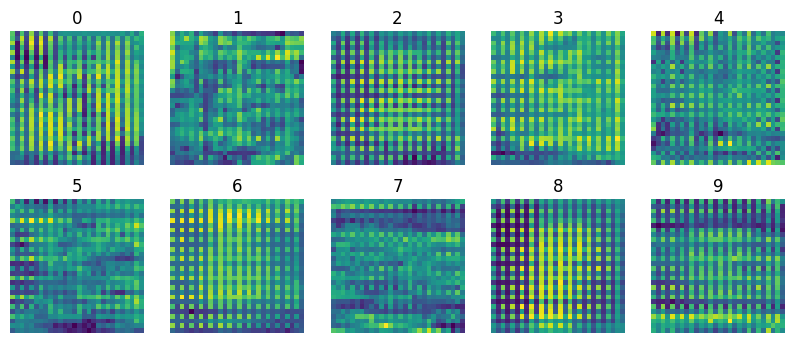

In [22]:
fig, axs = plt.subplots(2,5, figsize=(10,4))
for i in range(10):
    invNet = net_list[i]
    icenter = invNet.center.data
    j, k = i//5, i%5
#     print(i, j, k)
    axs[j,k].imshow(icenter.data.cpu().reshape(28, 28))
    axs[j,k].set_title(f"{i}")
    axs[j,k].set_axis_off()
# fig.tight_layout()
plt.savefig("./invex_out/MNIST_BasicInvex_cnn_centroids.pdf")
plt.show()

## Invertible+Cone = Invex

In [11]:
from nflib.flows import SequentialFlow, ActNorm, ActNorm2D
from nflib import res_flow as irf

In [12]:
from classes import DistanceRegressor

In [13]:
class InvCNN_MNIST(nn.Module):
    
    def __init__(self):
        super().__init__()
        actf = irf.LeakyReLU

        flows = [
            ActNorm2D(1),
            irf.ConvResidualFlow([1, 28, 28], [16], kernels=5, activation=actf),
            irf.InvertiblePooling(2),
            ActNorm2D(4),
            irf.ConvResidualFlow([4, 14, 14], [16], kernels=5, activation=actf),
            irf.InvertiblePooling(2),
            ActNorm2D(16),
            irf.ConvResidualFlow([16, 7, 7], [16], kernels=5, activation=actf),
            irf.Flatten(img_size=(16, 7, 7)),
            ActNorm(16*7*7),
            DistanceRegressor(16*7*7, inv_temp=0.25)
                ]
        self.model = nn.Sequential(*flows)
    
    def forward(self, x):
        x = x.reshape(-1,1, 28, 28)
        return self.model(x)

In [14]:
# use_mixup = True

In [15]:
stat_per_class = []
net_list = []
for class_idx in range(10):
    print(class_idx)
    train_dataset = MNIST_OneClass_Balanced(train_data, train_label, class_idx)
    test_dataset = MNIST_OneClass_Balanced(test_data, test_label, class_idx)

    train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

    torch.manual_seed(network_seed)
    Net = InvCNN_MNIST()
    optimizer = torch.optim.Adam(Net.parameters(), lr=learning_rate)
    losses = []
    train_accs = []
    test_accs = []

    index = 0
    for epoch in range(20):
        train_acc = 0
        train_count = 0
        for xx, yy in train_loader:
            index += 1

            if use_mixup:
                rand_indx = np.random.permutation(len(xx))
                rand_lambda = 1-torch.rand(len(xx), 1)*0.1
                x_mix = rand_lambda*xx+(1-rand_lambda)*xx[rand_indx]
                y_mix = rand_lambda*yy+(1-rand_lambda)*yy[rand_indx]
            else:
                x_mix = xx
                y_mix = yy

            yout = sigmoid(Net(x_mix))    
            loss = criterion(yout, y_mix)
            losses.append(float(loss))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
            correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
            train_acc += correct
            train_count += len(outputs)

#             if index%200 == 0:
        train_accs.append(float(train_acc)/train_count*100)
        train_acc = 0
        train_count = 0

        print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
        test_count = 0
        test_acc = 0
        for xx, yy in test_loader:
            with torch.no_grad():
                yout = sigmoid(Net(xx))
            outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
            correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
            test_acc += correct
            test_count += len(xx)
        test_accs.append(float(test_acc)/test_count*100)
        print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
        print()
                
    ### after each class index is finished training
    stat_per_class.append(
    f'Class: {class_idx} -> Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}'
    )
    print(stat_per_class[-1], '\n')
    net_list.append(Net)

0
Epoch: 0:237,  Loss:0.4122818112373352
Train Acc:67.64%, Test Acc:93.32%

Epoch: 1:474,  Loss:0.178267702460289
Train Acc:96.60%, Test Acc:98.37%

Epoch: 2:711,  Loss:0.1838635951280594
Train Acc:98.59%, Test Acc:99.34%

Epoch: 3:948,  Loss:0.2052469402551651
Train Acc:98.94%, Test Acc:99.29%

Epoch: 4:1185,  Loss:0.12574224174022675
Train Acc:99.10%, Test Acc:99.13%

Epoch: 5:1422,  Loss:0.11998306959867477
Train Acc:99.30%, Test Acc:99.23%

Epoch: 6:1659,  Loss:0.12569481134414673
Train Acc:99.39%, Test Acc:99.18%

Epoch: 7:1896,  Loss:0.13647200167179108
Train Acc:99.52%, Test Acc:99.29%

Epoch: 8:2133,  Loss:0.11129426211118698
Train Acc:99.57%, Test Acc:99.29%

Epoch: 9:2370,  Loss:0.10627156496047974
Train Acc:99.67%, Test Acc:99.49%

Epoch: 10:2607,  Loss:0.16590999066829681
Train Acc:99.69%, Test Acc:99.44%

Epoch: 11:2844,  Loss:0.13936731219291687
Train Acc:99.81%, Test Acc:99.49%

Epoch: 12:3081,  Loss:0.12985914945602417
Train Acc:99.76%, Test Acc:99.59%

Epoch: 13:3318, 

Epoch: 3:868,  Loss:0.20374953746795654
Train Acc:97.80%, Test Acc:97.59%

Epoch: 4:1085,  Loss:0.14797639846801758
Train Acc:98.16%, Test Acc:97.81%

Epoch: 5:1302,  Loss:0.18889416754245758
Train Acc:98.49%, Test Acc:97.81%

Epoch: 6:1519,  Loss:0.15465787053108215
Train Acc:98.75%, Test Acc:98.15%

Epoch: 7:1736,  Loss:0.1411236971616745
Train Acc:98.95%, Test Acc:98.32%

Epoch: 8:1953,  Loss:0.2027600109577179
Train Acc:99.02%, Test Acc:98.77%

Epoch: 9:2170,  Loss:0.1296105533838272
Train Acc:99.06%, Test Acc:98.77%

Epoch: 10:2387,  Loss:0.15270866453647614
Train Acc:99.27%, Test Acc:98.32%

Epoch: 11:2604,  Loss:0.18694594502449036
Train Acc:99.44%, Test Acc:98.77%

Epoch: 12:2821,  Loss:0.12338035553693771
Train Acc:99.51%, Test Acc:98.71%

Epoch: 13:3038,  Loss:0.13464945554733276
Train Acc:99.52%, Test Acc:98.21%

Epoch: 14:3255,  Loss:0.15215565264225006
Train Acc:99.59%, Test Acc:99.05%

Epoch: 15:3472,  Loss:0.10928938537836075
Train Acc:99.80%, Test Acc:98.54%

Epoch: 16:

In [16]:
## find the classification error from classification per class network.
acc_test = 0
count_test = 0
with torch.no_grad():
    for index in range(len(test_label) // batch_size):
        xx = test_data[index * batch_size:(index + 1) * batch_size]
        yy = test_label[index * batch_size:(index + 1) * batch_size]
        yout = []
        for net in net_list:
            yout.append(sigmoid(net(xx)).reshape(-1))
        yout = torch.stack(yout, dim=1).argmax(dim=1)
        acc = (yout == yy).type(torch.float32).sum()
        count_test += len(xx)
        acc_test += acc
        
for s in stat_per_class:
    print(s)
print(f"Total Accuracy (Argmax) is : {float(acc_test/count_test)}")

Class: 0 -> Train Acc 99.94934999155834 ; Test Acc 99.64285714285714
Class: 1 -> Train Acc 99.94808662118065 ; Test Acc 99.51541850220265
Class: 2 -> Train Acc 99.86572675394427 ; Test Acc 99.12790697674419
Class: 3 -> Train Acc 99.8858261295058 ; Test Acc 99.15841584158416
Class: 4 -> Train Acc 99.81170831906881 ; Test Acc 99.38900203665987
Class: 5 -> Train Acc 99.88931931377975 ; Test Acc 99.04708520179372
Class: 6 -> Train Acc 99.83102399459277 ; Test Acc 99.53027139874739
Class: 7 -> Train Acc 99.81644054269752 ; Test Acc 99.0272373540856
Class: 8 -> Train Acc 99.69236028029397 ; Test Acc 99.12731006160165
Class: 9 -> Train Acc 99.69742813918305 ; Test Acc 98.86025768087215
Total Accuracy (Argmax) is : 0.98089998960495


In [17]:
sum([p.numel() for p in net.parameters()])

19265

#### Visualize Centers

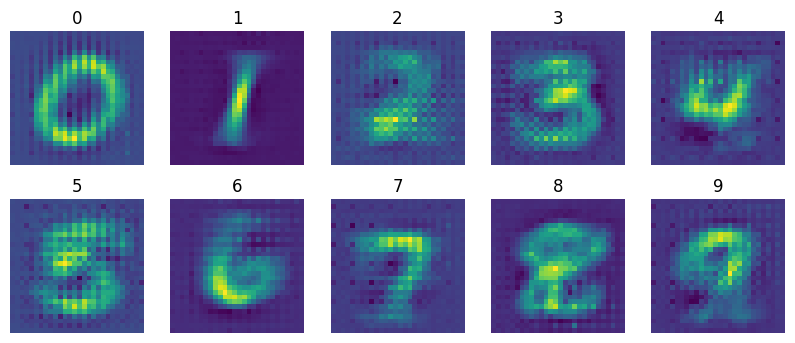

In [18]:
fig, axs = plt.subplots(2,5, figsize=(10,4))
for i in range(10):
    invNet = net_list[i]
    invertible = SequentialFlow([*invNet.model[:-1]])## excluding distance regressor
    icenter = invertible.inverse(invNet.model[-1].centers.data)
    j, k = i//5, i%5
#     print(i, j, k)
    axs[j,k].imshow(icenter.data.cpu().reshape(28, 28))
    axs[j,k].set_title(f"{i}")
    axs[j,k].set_axis_off()
# fig.tight_layout()
plt.savefig("./invex_out/MNIST_InvertibleInvex_cnn_centroids.pdf")
plt.show()